In [1]:
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.utils as utils
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np

Using TensorFlow backend.


In [2]:
space = [
    Integer(2, 30, name='target_dim'),
#     Integer(0, 1, name='hlf'),
    Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'), 
    Integer(3, 4, name='eflow_base')
]

In [3]:
filtered = utils.summary().cfilter([elt.name for elt in space] + ["*auc"])

keep = filtered.copy()
for elt in space:
    if isinstance(elt, Categorical):
        keep = keep[keep[elt.name].isin(elt.categories)]
    else:
        keep = keep[keep[elt.name].between(*elt.bounds)]
        if isinstance(elt, Integer):
            keep = keep[keep[elt.name].apply(lambda x: float(x).is_integer())]

aucs = keep.loc[:,~keep.columns.isin([elt.name for elt in space])]

x0 = np.asarray([keep[item.name].values for item in space]).T.tolist()
y0 = map(lambda x: 1 - x,aucs.max(axis=1).tolist())
# x0 = [list(keep [item.name].values) for item in space]
# y0 = auc.max(axis=1).tolist()

In [18]:
random_state = 42

@use_named_args(space)
def objective(**X):
    print "computing configuration {}".format(X)
    
    # minimize 1 - auc
    auc = 1. - ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(X['eflow_base']),
        signal_path="data/signal/base_{}/*.h5".format(X['eflow_base']),
        epochs=100,
        hlf=1,
        eflow=0,
        target_dim=X['target_dim'],
#         val_split=X['val_split'],
        learning_rate=X['learning_rate'],
        optimizer='adam',
#         loss=X['loss'],
        seed=random_state,
        verbose=0,
    )
    
    print "Max AUC:", 1 - auc
    return auc

results = gp_minimize(
    objective, space, verbose=1, 
    n_calls=100, 
    n_random_starts=20, 
    random_state=random_state
)

Iteration No: 1 started. Evaluating function at random point.
computing configuration {'eflow_base': 4, 'learning_rate': 0.00035506214270707701, 'target_dim': 24}


/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/utils.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  modify.df.drop(d, axis=1, inplace=True)


Max AUC: 0.525689514828
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 103.4550
Function value obtained: 0.4743
Current minimum: 0.4743
Iteration No: 2 started. Evaluating function at random point.
computing configuration {'eflow_base': 3, 'learning_rate': 0.0021751953118777658, 'target_dim': 19}


KeyboardInterrupt: 

In [19]:
ev.ae_train(
    qcd_path='data/background/base_{}/*.h5'.format(3),
    signal_path="data/signal/base_{}/*.h5".format(3),
    epochs=100,
    hlf=1,
    eflow=0,
    target_dim=3,
    learning_rate=0.0003,
    optimizer='adam',
    verbose=1,
    norm_args={
        'norm_type': 'MinMaxScaler'
    }
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 3)                 1263      
_________________________________________________________________
decoder (Model)              (None, 7)                 1267      
Total params: 2,530
Trainable params: 2,530
Non-trainable params: 0
_________________________________________________________________
TRAINING WITH PARAMS >>>
epochs : 100
loss : mse
learning_rate : 0.0003
optimizer : adam
batch_size : 64
Train on 74596 samples, validate on 13164 samples
Epoch 1/100
74596/74596 [==============================] - 4s 49us/step - loss: 0.4561 - val_loss: 0.3253
Epoch 2/100
74596/74596 [==============================] - 2s 27us/step - loss: 0.3120 - val_loss: 0.2943
Epoch 3/100
74596/74596 [============

0.54081943938564425

In [4]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(results)
plt.show()

NameError: name 'results' is not defined

In [9]:
print "Best parameters:"
for i,elt in enumerate(space):
    print "{} = {}".format(elt.name, results.x[i])

Best parameters:
target_dim = 23
learning_rate = 0.00188567838748
eflow_base = 3


In [6]:
utils.summary().cfilter(['*auc', 'filename', 'target_dim', '*?time']).sort_values('mae_auc')[::-1].head(10)

,end_time,filename,mae_auc,mse_auc,start_time,target_dim
38,2019-08-05 20:49:31.622617,eflow3_22_v0,0.99946,0.999505,2019-08-05 20:45:53.606871,22
40,2019-08-05 20:56:06.530272,eflow3_25_v0,0.999335,0.999279,2019-08-05 20:52:09.527756,25
35,2019-08-05 20:40:25.463147,eflow3_30_v1,0.998863,0.998982,2019-08-05 20:37:31.017789,30
64,2019-08-05 23:09:26.061489,eflow3_23_v0,0.998777,0.998999,2019-08-05 23:07:09.136545,23
44,2019-08-05 22:00:29.218745,eflow3_22_v1,0.99863,0.998507,2019-08-05 21:57:40.205668,22
106,2019-08-06 01:16:19.565055,eflow3_23_v4,0.998262,0.998519,2019-08-06 01:12:31.452303,23
42,2019-08-05 21:01:46.235038,eflow3_24_v0,0.998107,0.998351,2019-08-05 20:58:33.531407,24
98,2019-08-06 00:49:31.420370,eflow3_30_v18,0.998074,0.998197,2019-08-06 00:45:55.054532,30
50,2019-08-05 22:42:17.412259,eflow3_19_v1,0.998035,0.99821,2019-08-05 22:40:34.506322,19
59,2019-08-05 22:58:55.442248,eflow3_21_v0,0.997939,0.998057,2019-08-05 22:56:38.732265,21


In [7]:
e = ev.ae_evaluation("eflow3_23_v0")

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/eflow3_23_v0.summary'
train_shell :: using saved model


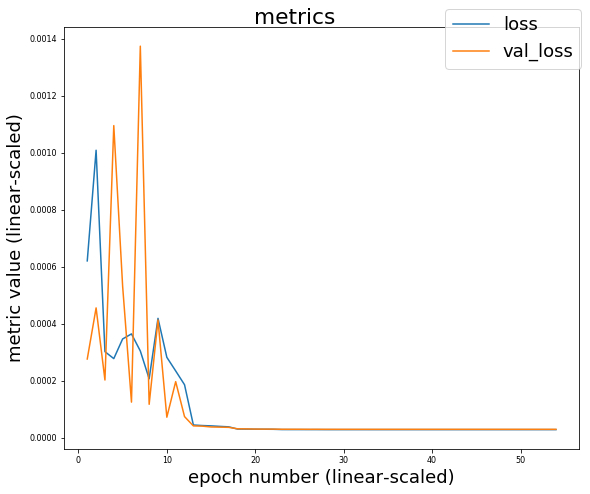

In [17]:
_ = e.metrics(figsize=(8,7), figloc='upper right', figname='metrics')

In [22]:
def pretty_plot(**fdict):

    cols = set().union(*[list(frame.columns) for frame in fdict.values()])
    parts = set().union(*[list(frame.index) for frame in fdict.values()])

    for name in fdict:
        fdict[name].fillna(0, inplace=True)

        for v in cols:
            if v not in fdict[name]:
                fdict[name][v] = 0
        for i in parts:
            if i not in fdict[name].index:
                fdict[name].loc[i] = 0

        fdict[name] = fdict[name][sorted(fdict[name].columns)]
        fdict[name].sort_index(inplace=True)

    for i,name in enumerate(fdict):
        ax = fdict[name].plot.bar(stacked=True, title=name, figsize=(8,8))
        ax.set_xlabel("PID")
        ax.set_ylabel("Count")

        legend = ax.get_legend()
        legend.set_title("Status")
    #     plt.suptitle(name)
        plt.show()
        
    return fdict


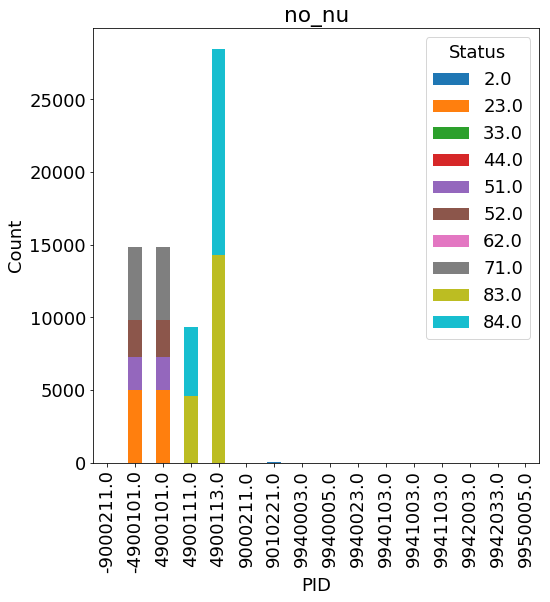

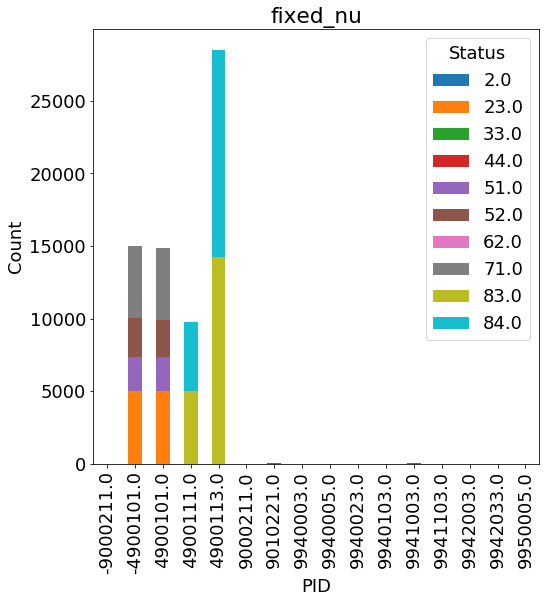

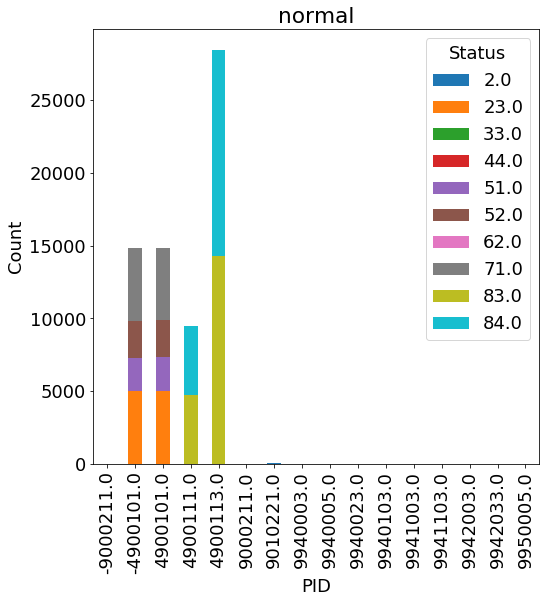

In [55]:
import matplotlib.pyplot as plt
fdict = pretty_plot(normal=normal.copy(), fixed_nu=fixed_nu.copy(), no_nu=no_nu.copy())